# Bayesian A/B Testing
### With examples adapted from "Bayesian Methods for Hackers" by Cameron Davidson-Pilon

### Problem
We have two Web site designs, called A and B. When a user lands on our Web site, we randomly show them design A or B, and record this assignment. After enough visitors have done this, we join this dataset against some metric of interest (typically, for Web sites, we are interested in a purchase or signup).

#### Which site has the highest conversion rate?

### Data

In [124]:
visitors_to_A = 2600
visitors_to_B = 1275

conversions_from_A = 240
conversions_from_B = 150


# posterior A is beta(1+240, 1+(2600-240))
# posterior B is beta(1+150, 1+(1275-150))

### Solution: Beta-Binomial model
Estimate the actual conversion rates $p_a$ and $p_b$

In [3]:
# Setup the environment
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
# figsize(11, 9)

### Prior

$p_a$, $p_b$ are both unknown variables in the interval $(0,1)$. Our priors for these come from a flat beta distribution. So each unknown conversion rate is modeled as a sample from a flat beta distribution:

$p_a \sim Beta(1 , 1) \qquad p_b \sim Beta(1 , 1)$

The prior probability of each conversion rate is:

$P(p_a) = Beta(p_a \mid 1,1) \qquad P(p_b) = Beta(p_b \mid 1,1)$

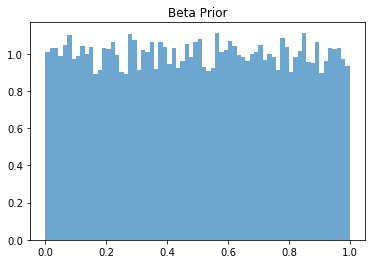

In [122]:
from scipy.stats import beta
uniform_beta_samples = beta(1,1).rvs(20000)
plt.hist(uniform_beta_samples, histtype="stepfilled", bins=70, normed=True, alpha=0.65);
plt.title("Beta Prior")

### Likelihood

#### The observed data can be modeled as a sample from a binomial distribution. 
$conversions_a \sim binom(N=visitors_a , p=p_a)$

#### The likelihood of the observed data is
$P(conversions \mid N , p) = binom(conversions_a \mid N=visitors_a , p=p_a)$


### Posterior = Likelihood $\times$ Prior
#### The posterior estimate for $p_a$ using Bayes rule:

$P(p_a \mid conversions_a, visitors_a) \propto P(conversions_a \mid visitors_a, p_a) \times P(p_a)$

#### Substituting in the distributions leads to:

$P(conversions_a \mid visitors_a, p_a) \times P(p_a) = binom(conversions_a \mid N=visitors_a, p=p_a) \times beta(p_a \mid 1,1)$

#### beta-binomial are a conjugate pair and have the following closed form posterior:

$binom(conversions_a \mid N=visitors_a, p=p_a) \times beta(p_a \mid 1,1) = beta(1+conversions_a, 1+(visitors_a-conversions_a))$

#### Therefore the simplified posterior for $p_a$ is:
$P(p_a \mid conversions_a, visitors_a) \propto beta(1+conversions_a, 1+(visitors_a-conversions_a))$

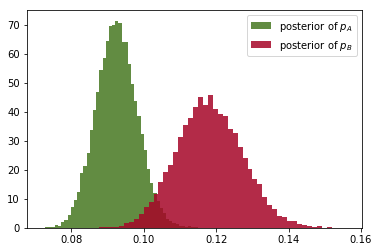

In [123]:
# Define the posterior distributions
posterior_A = beta(1 + conversions_from_A, 1 + visitors_to_A-conversions_from_A)
posterior_B = beta(1 + conversions_from_B, 1 + visitors_to_B-conversions_from_B)

# Draw samples from the posterior distributions
samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

# Plot the samples from the posterior distributions
plt.hist(samples_posterior_A, histtype="stepfilled", bins=50, normed=True, 
         alpha=0.85, color="#467821", label="posterior of $p_A$");
plt.hist(samples_posterior_B, histtype="stepfilled", bins=50, normed=True, 
         alpha=0.85, color="#A60628", label="posterior of $p_B$");
plt.legend();

In [6]:
agb = (samples_posterior_A > samples_posterior_B).mean()
print "The probability that A has higher conversion rate than B is %s" % agb

The probability that A has higher conversion rate than B is 0.00655


In [7]:
alb = (samples_posterior_A < samples_posterior_B).mean()
print "The probability that A has lower conversion rate than B is %s" % alb

The probability that A has lower conversion rate than B is 0.99345


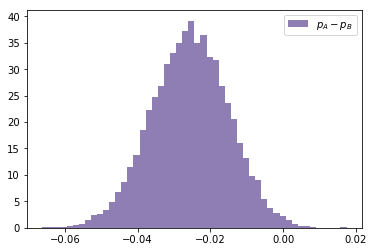

In [125]:
diff = samples_posterior_A-samples_posterior_B
plt.hist(diff, histtype="stepfilled", bins=50, normed=True, 
         alpha=0.85, color="#7A68A6", label="$p_A - p_B$");
plt.legend();

## Generalizing beyond A/B to multiple options

A common goal of Internet companies is not only to gain signups, but also to optimize which signup plan the user might select. For example, a business might want new customers to choose a higher-priced plan if presented with two or more plan options.
Suppose users are shown two different versions of this pricing page, and we’d like to determine the expected revenue we receive per impression.

<p>
Each page has 3 price plan options: \$79, \$49 and \$25.

For the moment, ignore the A/B test and consider the analysis for a single Web page style. In a completely transparent world, where we knew everything, we could calculate this expected value for this fictional company:

$E[R] = 79p_{79} + 49p_{49} + 25p_{25} + 0p_0$

where p79 is the probability of selecting the \$79 pricing plan, and so on. I’ve also included a fictional $0 pricing plan for someone who doesn’t pick a plan. This is added so that the probabilities sum to 1.

$p_{79} +p_{49} +p_{25} +p_0 =1$

### Data

In [60]:
# Page A
N_A    = 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0  = N_A - (N_A_79 + N_A_49 + N_A_25)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

# Page B
N_B    = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0  = N_B - (N_B_79 + N_B_49 + N_B_25)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

### The Dirichlet-Multinomial model

In [12]:
from scipy.stats import dirichlet

#### Analysis of just page A

In [25]:
prior_parameters = np.array([1,1,1,1])
# Dirichlet prior is Dirichlet([1,1,1,1])

posterior_samples_A = dirichlet.rvs(prior_parameters_A + observations_A,
size=10000)

#### Posterior Density function for Page A:

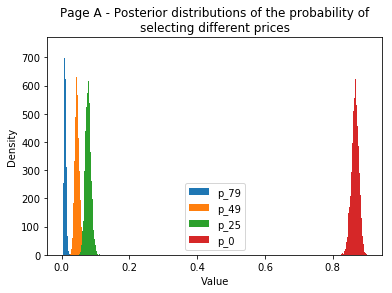

In [45]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']): ax = plt.hist(posterior_samples_A[:,i], bins=50,
                   label=label, histtype='stepfilled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Page A - Posterior distributions of the probability of\nselecting different prices")
plt.legend();

#### Consider expected revenue using a linear value function

In [23]:
def expected_revenue(P):
    return 79*P[:,0] + 49*P[:,1] + 25*P[:,2] + 0*P[:,3]

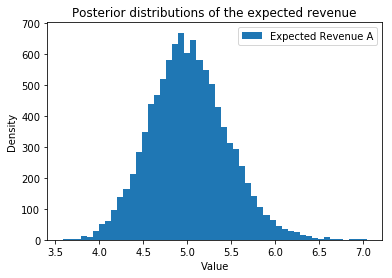

In [27]:
posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
plt.hist(posterior_expected_revenue_A, histtype='stepfilled',
        label='Expected Revenue A', bins=50)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the expected revenue")
plt.legend();

The expected revenue is likely between \$4 and \$6, and unlikely to be outside this range.

### Now consider the expected revenue for Page B compared to A

In [ ]:
posterior_samples_B = dirichlet.rvs(prior_parameters + observations_B,
                                   size=10000)
posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

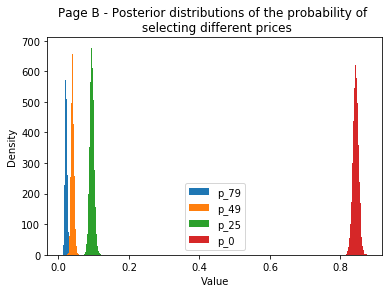

In [43]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']): ax = plt.hist(posterior_samples_B[:,i], bins=50,
                   label=label, histtype='stepfilled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Page B - Posterior distributions of the probability of \n selecting different prices")
plt.legend();

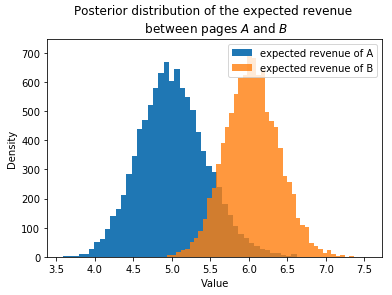

In [44]:
plt.hist(posterior_expected_revenue_A, histtype='stepfilled',
        label='expected revenue of A', bins=50)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled',
        label='expected revenue of B', bins=50, alpha=0.8)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the expected revenue \n between pages $A$ and $B$")
plt.legend();

In [35]:
p_b_greaterthan_a = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print "Probability that page B has a higher revenue than page A: %.3f"%p_b_greaterthan_a

Probability that page B has a higher revenue than page A: 0.964


#### Posterior of difference between EV of pages

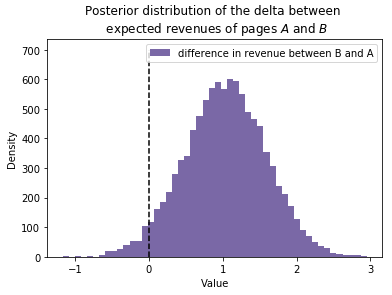

In [41]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6',
        label='difference in revenue between B and A', bins=50)
plt.vlines(0, 0, 700, linestyles='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the delta between \n expected revenues of pages $A$ and $B$")
plt.legend();

Looking at this posterior, we see that there is about a 50% chance that the difference is more than \$1, and possibly even larger than \$2. And if we are wrong about our choice of B (which is possible), we probably won’t lose much: The distribution doesn’t extend much past −\$0.50.

## Die Roll example

In [74]:
from scipy.stats import multinomial

In [113]:
die_prior = [1,1,1,1,1,1]
# define a fair die
die_probs = np.array([1./6,1./6,1./6,1./6,1./6,1./6])
die_probs = die_probs / np.sum(die_probs)
die = multinomial(n=1000000, p=die_probs) # n samples from a fair die

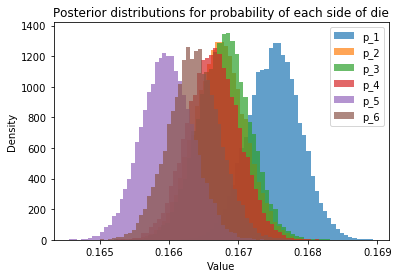

In [119]:
# generate the data
rolls = die.rvs()[0]

# get samples from posterior
die_post = dirichlet(d_prior + rolls)
die_post_samples = die_post.rvs(size=20000)

# plot the posterior
for i, label in enumerate(['p_1', 'p_2', 'p_3', 'p_4', 'p_5', 'p_6']): ax = plt.hist(die_post_samples[:,i], bins=50,
                   label=label, histtype='stepfilled', alpha=.7)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions for probability of each side of die")
plt.legend();